# Your goal in this challenge is to find the factors that affect the life expectancy. Specifically, you need to find out which factors increase the expected life in the countries and which factors decrease it.

In [342]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import warnings

warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

In [343]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'lifeexpectancy'
table_name = 'lifeexpectancy'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

lifeexp = pd.read_sql_query('select * from lifeexpectancy',con=engine)

engine.dispose()

lifeexp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
Country                            2938 non-null object
Year                               2938 non-null int64
Status                             2938 non-null object
Life expectancy                    2928 non-null float64
Adult Mortality                    2928 non-null float64
infant deaths                      2938 non-null int64
Alcohol                            2744 non-null float64
percentage expenditure             2938 non-null float64
Hepatitis B                        2385 non-null float64
Measles                            2938 non-null int64
 BMI                               2904 non-null float64
under-five deaths                  2938 non-null int64
Polio                              2919 non-null float64
Total expenditure                  2712 non-null float64
Diphtheria                         2919 non-null float64
 HIV/AIDS                          2938 non-null

# 1. Detect the problems with the data such as missing values and outliers. Are there any nonsense values that seem to be stemmed from the data collection? For the missing values, discuss which technique would be the most suitable one in filling out these values. Regarding the outliers, discuss their potential effects on your analysis and select an appropriate method to deal with them.

In [350]:
lifeexp.isnull().sum()
lifeexp.isnull().sum()*100/lifeexp.isnull().count()

# no missing value for categorical varaiable; some missing value for continuous variable

Country                             0.000000
Year                                0.000000
Status                              0.000000
Life expectancy                     0.340368
Adult Mortality                     0.340368
infant deaths                       0.000000
Alcohol                             6.603131
percentage expenditure              0.000000
Hepatitis B                        18.822328
Measles                             0.000000
 BMI                                1.157250
under-five deaths                   0.000000
Polio                               0.646698
Total expenditure                   7.692308
Diphtheria                          0.646698
 HIV/AIDS                           0.000000
GDP                                15.248468
Population                         22.191967
 thinness  1-19 years               1.157250
 thinness 5-9 years                 1.157250
Income composition of resources     5.684139
Schooling                           5.547992
dtype: flo

In [351]:
# change the column names to all lower case, connected with _, no space.

df = lifeexp.copy()
df.columns = ['_'.join(x.split()) for x in list([x.str.strip().str.lower() for x in [df.columns]])[0]]
df.columns

Index(['country', 'year', 'status', 'life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling'],
      dtype='object')

In [355]:
# fill missing values with the mean value corresponding to each country.
# if the column value is all null or only has 1 unique value for that country, then fill it with 0.
# tried to use the interpolated value, but have way more NaN value still. and thus stick with mean for now. 
# i can always modify this after taking out the ourliars to make the data smooth.

fill_list = ['life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling']

countries = df['country'].unique()

for col in fill_list:
    for country in countries: 
        if len(df.loc[df["country"] == country][col].unique())==1: 
            df.loc[df["country"] == country, col]= df.loc[df["country"] == country, col].fillna(0)
        else: 
            df.loc[df['country'] == country, col] = df.loc[df["country"] == country, col].fillna(
                df[(df["country"] == country) & (df[col].isnull()==False)][col].mean())

In [356]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 22 columns):
country                            2938 non-null object
year                               2938 non-null int64
status                             2938 non-null object
life_expectancy                    2938 non-null float64
adult_mortality                    2938 non-null float64
infant_deaths                      2938 non-null int64
alcohol                            2938 non-null float64
percentage_expenditure             2938 non-null float64
hepatitis_b                        2938 non-null float64
measles                            2938 non-null int64
bmi                                2938 non-null float64
under-five_deaths                  2938 non-null int64
polio                              2938 non-null float64
total_expenditure                  2938 non-null float64
diphtheria                         2938 non-null float64
hiv/aids                           2938 non-null

In [ ]:
# we can use descibe() to see whether there is a big diff

In [357]:
lifeexp.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


In [358]:
df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,polio,total_expenditure,diphtheria,hiv/aids,gdp,population,thinness_1-19_years,thinness_5-9_years,income_composition_of_resources,schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.00000,2938.000000
mean,2007.518720,68.989312,164.235534,30.303948,4.574228,738.251295,74.793336,2419.592240,37.877774,42.035739,82.396266,5.856477,82.183944,1.742103,6361.299758,9.925971e+06,4.783696,4.813955,0.59188,11.327434
std,4.613841,10.327437,124.451093,117.926501,4.042375,1987.914858,29.858640,11467.272489,20.344920,160.445548,23.476067,2.531511,23.743205,5.077785,13402.383592,5.407539e+07,4.424924,4.512880,0.25114,4.265626
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.000000,2.000000,0.100000,0.000000,0.000000e+00,0.000000,0.000000,0.00000,0.000000
25%,2004.000000,63.000000,73.000000,0.000000,0.852500,4.685343,65.461538,0.000000,19.000000,0.000000,78.000000,4.220000,78.000000,0.100000,234.463634,6.281500e+03,1.500000,1.500000,0.46500,9.500000
50%,2008.000000,72.000000,144.000000,3.000000,3.685000,64.912906,88.000000,17.000000,43.000000,4.000000,93.000000,5.710000,93.000000,0.100000,1178.176979,5.448670e+05,3.300000,3.300000,0.66200,12.100000
75%,2012.000000,75.600000,227.000000,22.000000,7.677500,441.534144,96.000000,360.250000,56.100000,28.000000,97.000000,7.430000,97.000000,0.800000,4779.405190,4.584371e+06,7.100000,7.200000,0.77200,14.100000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.600000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.94800,20.700000


overall, the chagnes in datasets after filling the null value are not dramatic.
now lets look at outliars:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017AEEF2EDD8>,
      dtype=object)

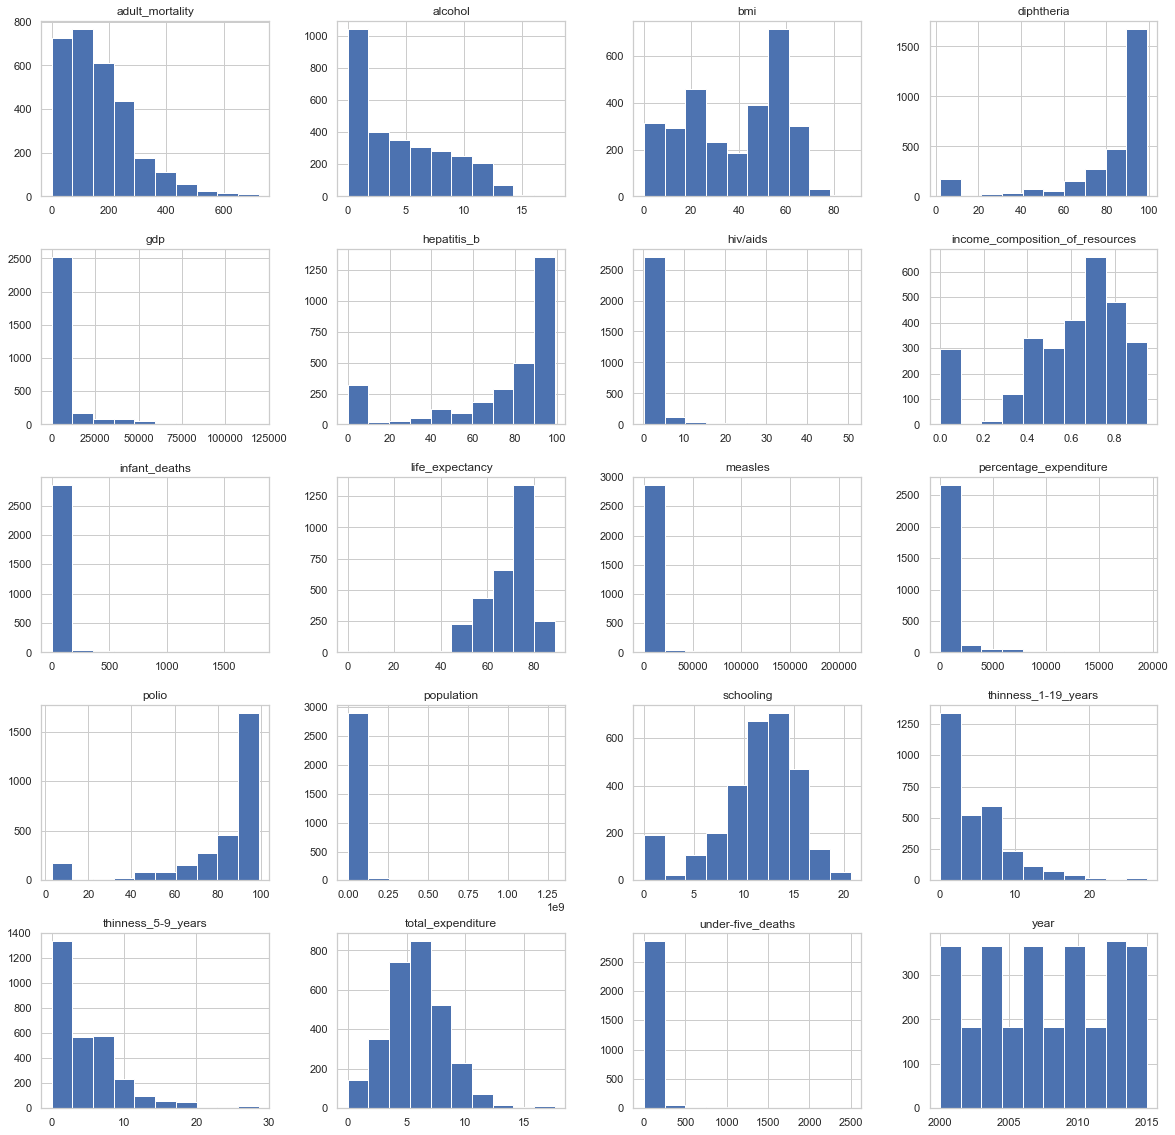

In [359]:
# lets take a visual look using histgram
df.hist(figsize=(20,20))

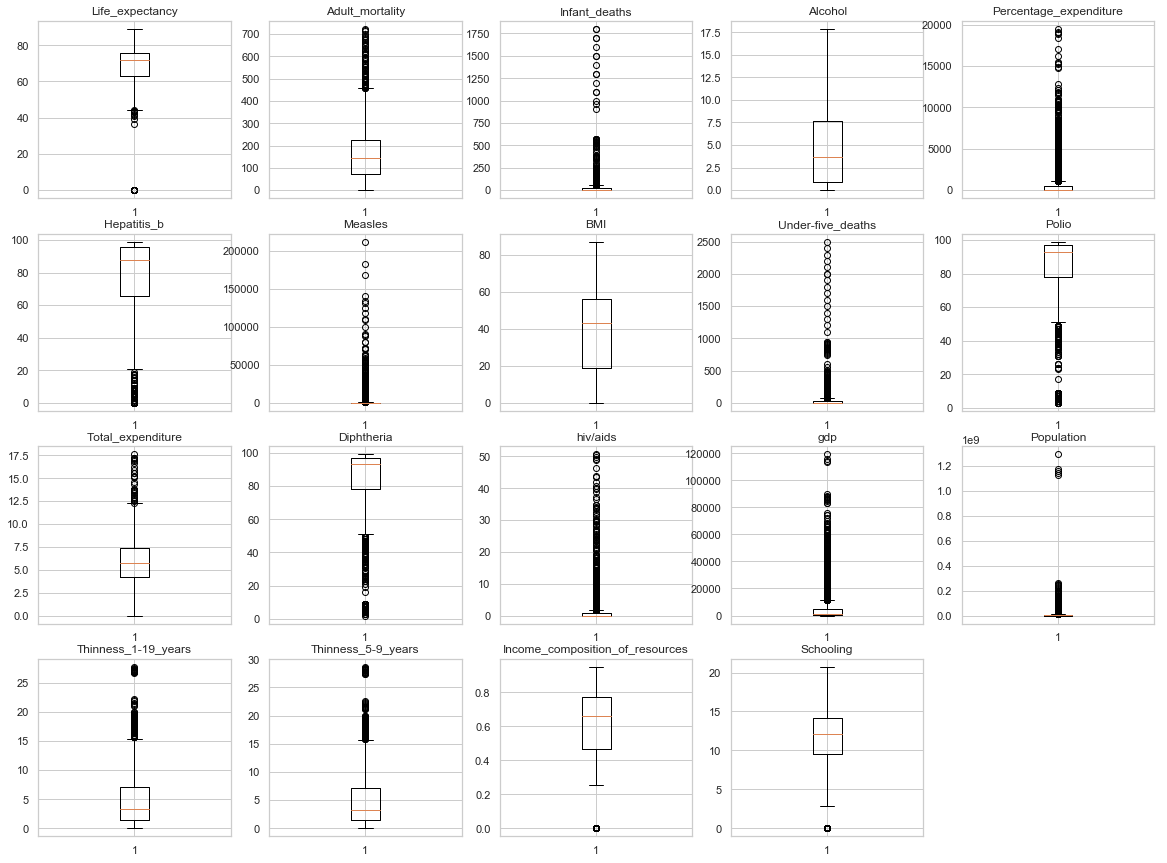

In [360]:
# use boxplot
plt.figure(figsize = (20, 15))

plt.subplot(4,5,1)
plt.boxplot(df["life_expectancy"])
plt.title("Life_expectancy")

plt.subplot(4,5,2)
plt.boxplot(df["adult_mortality"])
plt.title("Adult_mortality")

plt.subplot(4,5,3)
plt.boxplot(df["infant_deaths"])
plt.title("Infant_deaths")

plt.subplot(4,5,4)
plt.boxplot(df["alcohol"])
plt.title("Alcohol")

plt.subplot(4,5,5)
plt.boxplot(df["percentage_expenditure"])
plt.title("Percentage_expenditure")

plt.subplot(4,5,6)
plt.boxplot(df["hepatitis_b"])
plt.title("Hepatitis_b")

plt.subplot(4,5,7)
plt.boxplot(df["measles"])
plt.title("Measles")

plt.subplot(4,5,8)
plt.boxplot(df["bmi"])
plt.title("BMI")

plt.subplot(4,5,9)
plt.boxplot(df["under-five_deaths"])
plt.title("Under-five_deaths")

plt.subplot(4,5,10)
plt.boxplot(df["polio"])
plt.title("Polio")

plt.subplot(4,5,11)
plt.boxplot(df["total_expenditure"])
plt.title("Total_expenditure")

plt.subplot(4,5,12)
plt.boxplot(df["diphtheria"])
plt.title("Diphtheria")

plt.subplot(4,5,13)
plt.boxplot(df["hiv/aids"])
plt.title("hiv/aids")

plt.subplot(4,5,14)
plt.boxplot(df["gdp"])
plt.title("gdp")

plt.subplot(4,5,15)
plt.boxplot(df["population"])
plt.title("Population")

plt.subplot(4,5,16)
plt.boxplot(df["thinness_1-19_years"])
plt.title("Thinness_1-19_years")

plt.subplot(4,5,17)
plt.boxplot(df["thinness_5-9_years"])
plt.title("Thinness_5-9_years")

plt.subplot(4,5,18)
plt.boxplot(df["income_composition_of_resources"])
plt.title("Income_composition_of_resources")

plt.subplot(4,5,19)
plt.boxplot(df["schooling"])
plt.title("Schooling")



plt.show()

In [361]:
# lets use Tukey test to see how many outliars we have per 1.5 IQR

fill_list = ['life_expectancy', 'adult_mortality',
       'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b',
       'measles', 'bmi', 'under-five_deaths', 'polio', 'total_expenditure',
       'diphtheria', 'hiv/aids', 'gdp', 'population', 'thinness_1-19_years',
       'thinness_5-9_years', 'income_composition_of_resources', 'schooling']


for col in fill_list:
    q75, q25 = np.percentile(df[col], [75 ,25])
    iqr = q75 - q25
    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)
    
    print("Outliers for {} \n   Number: {} and Percetage {} .".format(col, 
                len((np.where((df[col] > max_val)|(df[col] < min_val))[0])), 
                len((np.where((df[col] > max_val)|(df[col] < min_val))[0]))*100/2938))                                            
                                                      
# no outliars for alcohol, bmi.                                                    

Outliers for life_expectancy 
   Number: 20 and Percetage 0.6807351940095303 .
Outliers for adult_mortality 
   Number: 85 and Percetage 2.893124574540504 .
Outliers for infant_deaths 
   Number: 315 and Percetage 10.721579305650103 .
Outliers for alcohol 
   Number: 0 and Percetage 0.0 .
Outliers for percentage_expenditure 
   Number: 389 and Percetage 13.240299523485364 .
Outliers for hepatitis_b 
   Number: 333 and Percetage 11.334240980258679 .
Outliers for measles 
   Number: 542 and Percetage 18.44792375765827 .
Outliers for bmi 
   Number: 0 and Percetage 0.0 .
Outliers for under-five_deaths 
   Number: 394 and Percetage 13.410483321987746 .
Outliers for polio 
   Number: 290 and Percetage 9.87066031313819 .
Outliers for total_expenditure 
   Number: 34 and Percetage 1.1572498298162015 .
Outliers for diphtheria 
   Number: 309 and Percetage 10.517358747447243 .
Outliers for hiv/aids 
   Number: 542 and Percetage 18.44792375765827 .
Outliers for gdp 
   Number: 430 and Percetage 

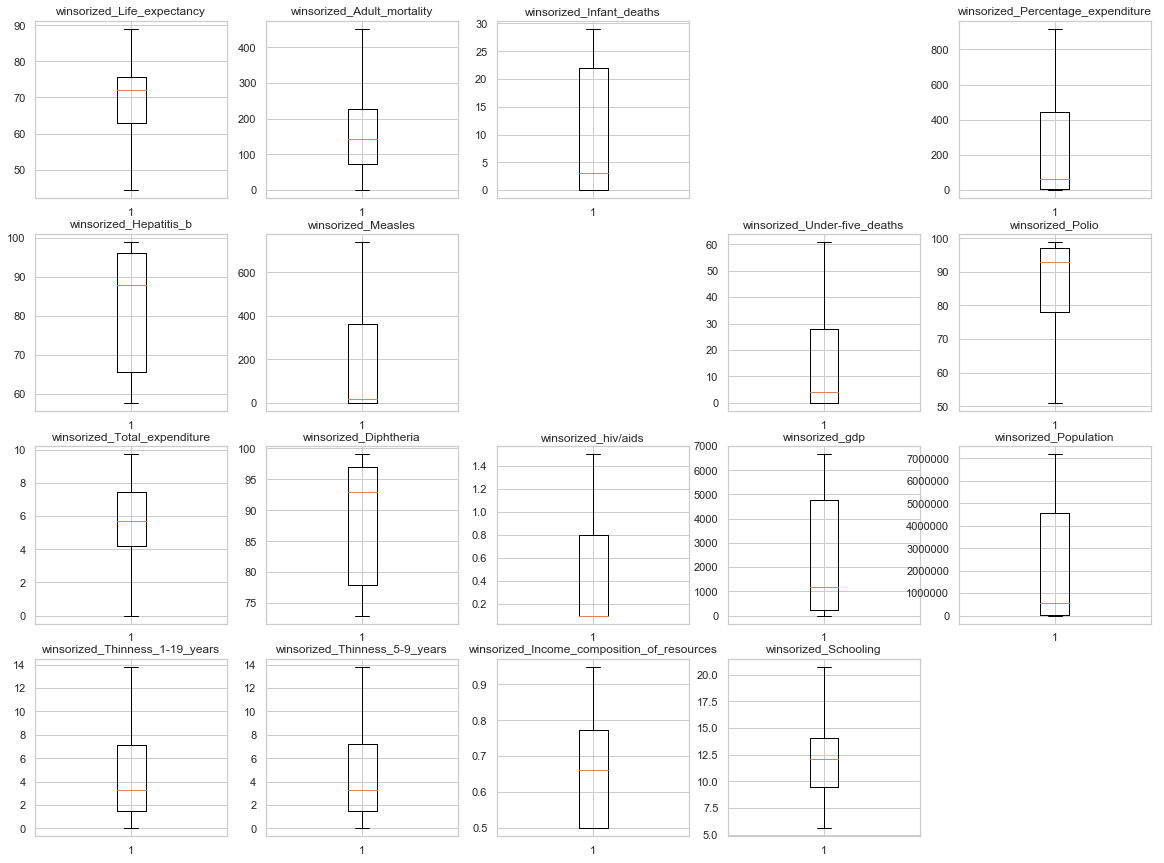

In [362]:
# to treat outliars, i will winsorize each of them 
# no outliars for alcohol, bmi from previous tukey test, so wont winsorize those two here.   

from scipy.stats.mstats import winsorize


winsorized_life_expectancy = winsorize(df["life_expectancy"], (0.007,0))
winsorized_adult_mortality = winsorize(df["adult_mortality"], (0,0.03))
winsorized_infant_deaths = winsorize(df["infant_deaths"], (0,0.2))
#winsorized_alcohol = winsorize(df["alcohol"], (0.02,0))
winsorized_percentage_expenditure = winsorize(df["percentage_expenditure"], (0,0.15))
winsorized_hepatitis_b = winsorize(df["hepatitis_b"], (0.2,0))
winsorized_measles = winsorize(df["measles"], (0,0.2))
#winsorized_bmi = winsorize(df["bmi"], (0.05,0))
winsorized_under_five_deaths = winsorize(df["under-five_deaths"], (0,0.15))
winsorized_polio = winsorize(df["polio"], (0.1,0))
winsorized_total_expenditure = winsorize(df["total_expenditure"], (0,0.05))
winsorized_diphtheria = winsorize(df["diphtheria"], (0.2,0))
winsorized_hivaids = winsorize(df["hiv/aids"], (0,0.2))
winsorized_gdp = winsorize(df["gdp"], (0,0.2))
winsorized_population = winsorize(df["population"], (0,0.2))
winsorized_thinness_1_19_years = winsorize(df["thinness_1-19_years"], (0,0.05))
winsorized_thinness_5_9_years = winsorize(df["thinness_5-9_years"], (0,0.05))
winsorized_income_composition_of_resources = winsorize(df["income_composition_of_resources"], (0.3,0))
winsorized_schooling = winsorize(df["schooling"], (0.1,0))

plt.figure(figsize = (20, 15))

plt.subplot(4,5,1)
plt.boxplot(winsorized_life_expectancy)
plt.title("winsorized_Life_expectancy")

plt.subplot(4,5,2)
plt.boxplot(winsorized_adult_mortality)
plt.title("winsorized_Adult_mortality")

plt.subplot(4,5,3)
plt.boxplot(winsorized_infant_deaths)
plt.title("winsorized_Infant_deaths")



plt.subplot(4,5,5)
plt.boxplot(winsorized_percentage_expenditure)
plt.title("winsorized_Percentage_expenditure")

plt.subplot(4,5,6)
plt.boxplot(winsorized_hepatitis_b)
plt.title("winsorized_Hepatitis_b")

plt.subplot(4,5,7)
plt.boxplot(winsorized_measles)
plt.title("winsorized_Measles")




plt.subplot(4,5,9)
plt.boxplot(winsorized_under_five_deaths)
plt.title("winsorized_Under-five_deaths")

plt.subplot(4,5,10)
plt.boxplot(winsorized_polio)
plt.title("winsorized_Polio")

plt.subplot(4,5,11)
plt.boxplot(winsorized_total_expenditure)
plt.title("winsorized_Total_expenditure")

plt.subplot(4,5,12)
plt.boxplot(winsorized_diphtheria)
plt.title("winsorized_Diphtheria")

plt.subplot(4,5,13)
plt.boxplot(winsorized_hivaids)
plt.title("winsorized_hiv/aids")

plt.subplot(4,5,14)
plt.boxplot(winsorized_gdp)
plt.title("winsorized_gdp")

plt.subplot(4,5,15)
plt.boxplot(winsorized_population)
plt.title("winsorized_Population")

plt.subplot(4,5,16)
plt.boxplot(winsorized_thinness_1_19_years)
plt.title("winsorized_Thinness_1-19_years")

plt.subplot(4,5,17)
plt.boxplot(winsorized_thinness_5_9_years)
plt.title("winsorized_Thinness_5-9_years")

plt.subplot(4,5,18)
plt.boxplot(winsorized_income_composition_of_resources)
plt.title("winsorized_Income_composition_of_resources")

plt.subplot(4,5,19)
plt.boxplot(winsorized_schooling)
plt.title("winsorized_Schooling")



plt.show()

In [363]:
# use Tukey to test again stattistically whether there are any outliars
# no outliars for original alcohol, bmi, so they are not inclued in the below list.   

fill_winsorized = [winsorized_life_expectancy, winsorized_adult_mortality,
       winsorized_infant_deaths,  winsorized_percentage_expenditure, winsorized_hepatitis_b,
       winsorized_measles, winsorized_under_five_deaths, winsorized_polio, winsorized_total_expenditure,
       winsorized_diphtheria, winsorized_hivaids, winsorized_gdp, winsorized_population, winsorized_thinness_1_19_years,
       winsorized_thinness_5_9_years, winsorized_income_composition_of_resources, winsorized_schooling]



for col in fill_winsorized:
    q75, q25 = np.percentile(col, [75 ,25])
    iqr = q75 - q25


    min_val = q25 - (iqr*1.5)
    max_val = q75 + (iqr*1.5)

    print(" {} Number of outliers after winsorization: {}".format(col, len(np.where((col > max_val) 
                      | (col < min_val))[0])))                                                     

 [65.  59.9 59.9 ... 44.8 45.3 46. ] Number of outliers after winsorization: 0
 [263. 271. 268. ...  73. 452. 452.] Number of outliers after winsorization: 0
 [29 29 29 ... 25 25 24] Number of outliers after winsorization: 0
 [71.27962362 73.52358168 73.21924272 ...  0.          0.
  0.        ] Number of outliers after winsorization: 0
 [65. 62. 64. ... 73. 76. 79.] Number of outliers after winsorization: 0
 [741 492 430 ... 304 529 741] Number of outliers after winsorization: 0
 [61 61 61 ... 40 39 39] Number of outliers after winsorization: 0
 [51. 58. 62. ... 73. 76. 78.] Number of outliers after winsorization: 0
 [8.16 8.18 8.13 ... 6.53 6.16 7.1 ] Number of outliers after winsorization: 0
 [73. 73. 73. ... 73. 75. 78.] Number of outliers after winsorization: 0
 [0.1 0.1 0.1 ... 1.5 1.5 1.5] Number of outliers after winsorization: 0
 [584.25921   612.696514  631.744976  ...  57.34834   548.587312
 547.3588785] Number of outliers after winsorization: 0
 [7182451.  327582. 7182451. 

In [364]:
# winsorized data looks good, so adding them to the dataframe
# no outliars for original alcohol, bmi data (from the first tukey test), so keep the original data.   
# adding 17 new columns

df['winsorized_life_expectancy'] = winsorized_life_expectancy 
df['winsorized_adult_mortality'] = winsorized_adult_mortality
df['winsorized_infant_deaths'] = winsorized_infant_deaths
df['winsorized_percentage_expenditure'] = winsorized_percentage_expenditure
df['winsorized_hepatitis_b'] = winsorized_hepatitis_b
df['winsorized_measles'] =winsorized_measles
df['winsorized_under_five_deaths'] = winsorized_under_five_deaths
df['winsorized_polio'] = winsorized_polio
df['winsorized_total_expenditure'] = winsorized_total_expenditure
df['winsorized_diphtheria'] = winsorized_diphtheria
df['winsorized_hivaids'] = winsorized_hivaids
df['winsorized_gdp'] = winsorized_gdp
df['winsorized_population'] = winsorized_population
df['winsorized_thinness_1_19_years'] = winsorized_thinness_1_19_years
df['winsorized_thinness_5_9_years'] = winsorized_thinness_5_9_years
df['winsorized_income_composition_of_resources'] = winsorized_income_composition_of_resources
df['winsorized_schooling'] = winsorized_schooling


df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2938 entries, 0 to 2937
Data columns (total 39 columns):
country                                       2938 non-null object
year                                          2938 non-null int64
status                                        2938 non-null object
life_expectancy                               2938 non-null float64
adult_mortality                               2938 non-null float64
infant_deaths                                 2938 non-null int64
alcohol                                       2938 non-null float64
percentage_expenditure                        2938 non-null float64
hepatitis_b                                   2938 non-null float64
measles                                       2938 non-null int64
bmi                                           2938 non-null float64
under-five_deaths                             2938 non-null int64
polio                                         2938 non-null float64
total_expenditure  

# 2.Explore the data using univariate and multivariate exploration techniques. You should pay special attention to your target variable. In this regard, your focus should be on finding the relevant variables that may affect life expectancy.

In [365]:
df.describe()

,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,bmi,under-five_deaths,...,winsorized_polio,winsorized_total_expenditure,winsorized_diphtheria,winsorized_hivaids,winsorized_gdp,winsorized_population,winsorized_thinness_1_19_years,winsorized_thinness_5_9_years,winsorized_income_composition_of_resources,winsorized_schooling
count,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,...,2938.000000,2938.000000,2938.000000,2938.000000,2938.000000,2.938000e+03,2938.000000,2938.000000,2938.000000,2938.000000
mean,2007.518720,68.989312,164.235534,30.303948,4.574228,738.251295,74.793336,2419.592240,37.877774,42.035739,...,85.303686,5.753964,88.356365,0.469197,2450.964181,2.245999e+06,4.585398,4.592001,0.658180,11.722124
std,4.613841,10.327437,124.451093,117.926501,4.042375,1987.914858,29.858640,11467.272489,20.344920,160.445548,...,15.630623,2.281850,9.825311,0.569172,2590.319940,2.867734e+06,3.799014,3.811031,0.138729,3.380832
min,2000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,51.000000,0.000000,73.000000,0.100000,0.000000,0.000000e+00,0.000000,0.000000,0.499000,5.600000
25%,2004.000000,63.000000,73.000000,0.000000,0.852500,4.685343,65.461538,0.000000,19.000000,0.000000,...,78.000000,4.220000,78.000000,0.100000,234.463634,6.281500e+03,1.500000,1.500000,0.499000,9.500000
50%,2008.000000,72.000000,144.000000,3.000000,3.685000,64.912906,88.000000,17.000000,43.000000,4.000000,...,93.000000,5.710000,93.000000,0.100000,1178.176979,5.448670e+05,3.300000,3.300000,0.662000,12.100000
75%,2012.000000,75.600000,227.000000,22.000000,7.677500,441.534144,96.000000,360.250000,56.100000,28.000000,...,97.000000,7.430000,97.000000,0.800000,4779.405190,4.584371e+06,7.100000,7.200000,0.772000,14.100000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,...,99.000000,9.720000,99.000000,1.500000,6651.122420,7.182451e+06,13.800000,13.800000,0.948000,20.700000


In [366]:
# creating the features list:
# it will include two original datasets alcohol, bmi (since they do not have outliars for from the first tukey test)
# and the newly added 17 winsorized data.
# total 19

features = ['alcohol', 'bmi', 'winsorized_life_expectancy', 'winsorized_adult_mortality',
       'winsorized_infant_deaths',  'winsorized_percentage_expenditure', 'winsorized_hepatitis_b',
       'winsorized_measles', 'winsorized_under_five_deaths', 'winsorized_polio', 'winsorized_total_expenditure',
       'winsorized_diphtheria', 'winsorized_hivaids', 'winsorized_gdp', 'winsorized_population', 'winsorized_thinness_1_19_years',
       'winsorized_thinness_5_9_years', 'winsorized_income_composition_of_resources', 'winsorized_schooling']

len(features)


19

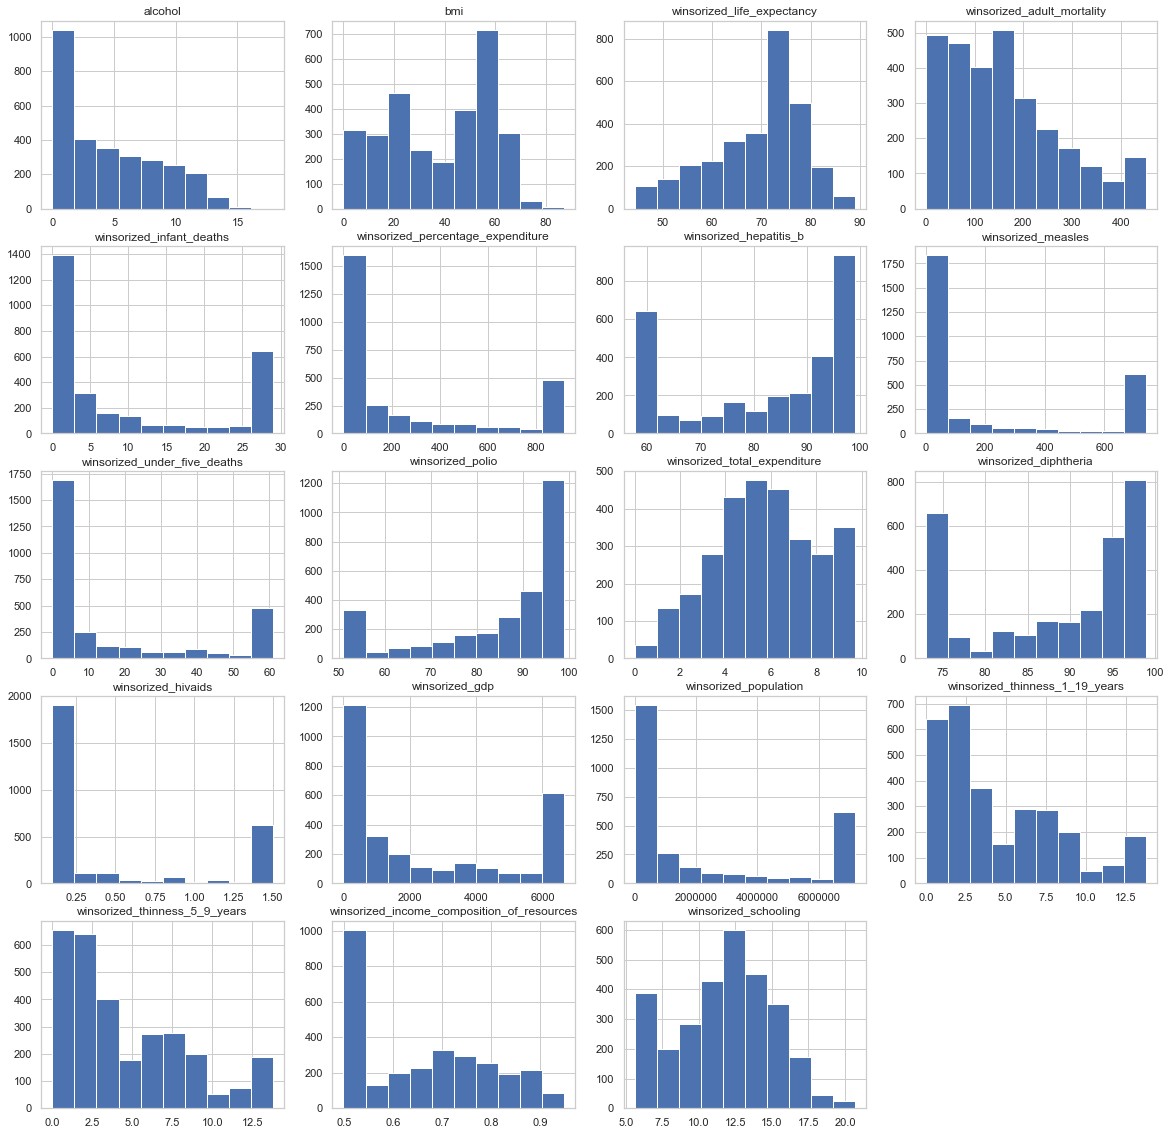

In [367]:
# visualization of continuous variables

plt.figure(figsize=(20,20))

for i in range(len(features)):
    plt.subplot(5,4,i+1)
    plt.hist(df[features[i]])
    plt.title(features[i])

plt.show()

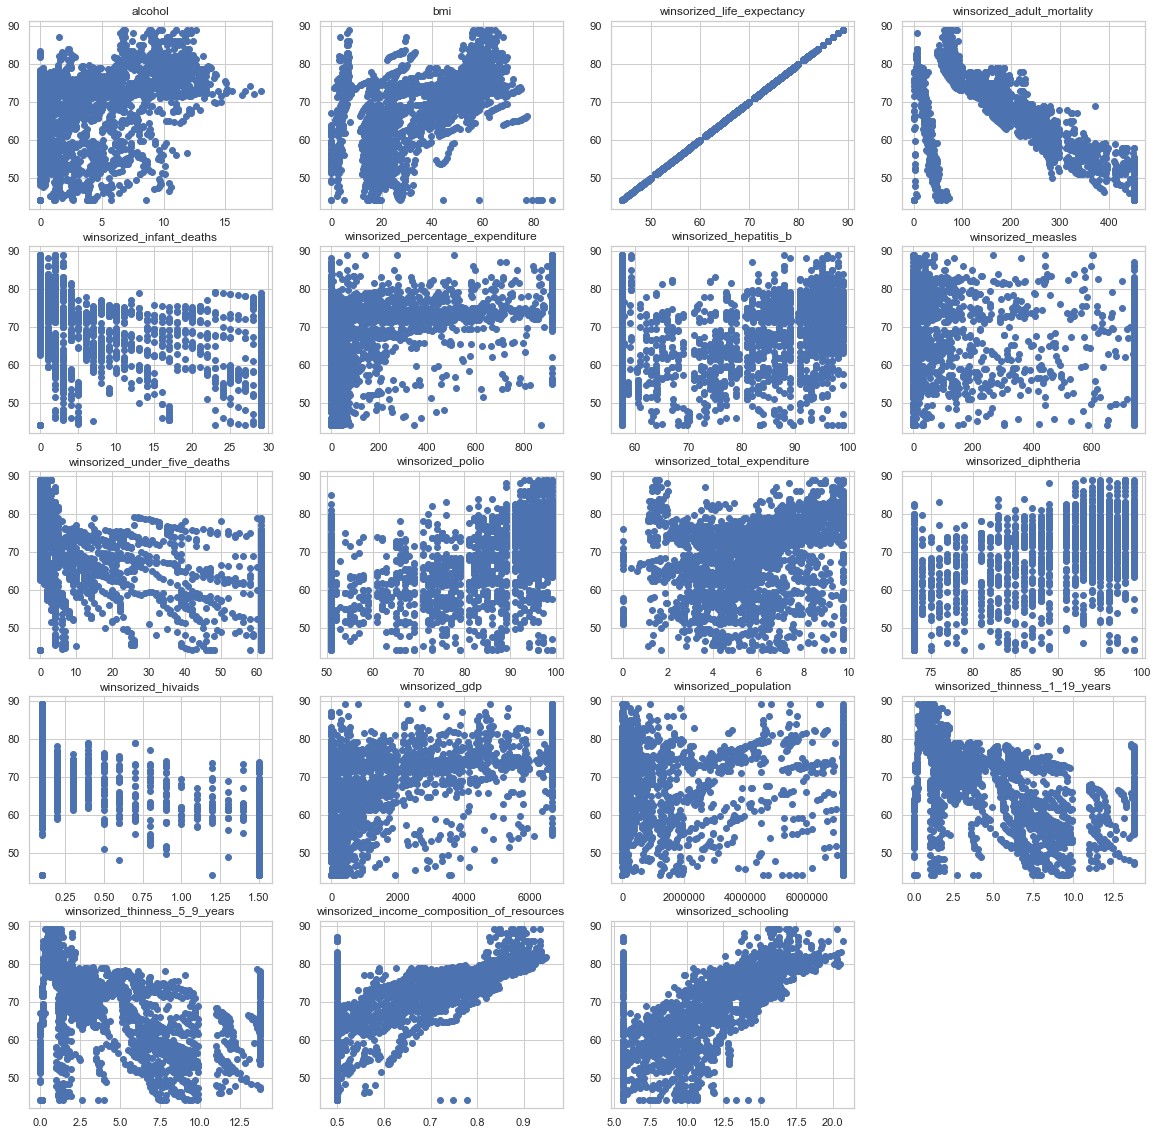

In [368]:
# now use the scaterplot to see the relationships between winsorized_life_expectancy and other features


plt.figure(figsize=(20,20))

for i in range(len(features)):
    plt.subplot(5,4,i+1)
    plt.scatter(df[features[i]],y=df['winsorized_life_expectancy'])
    plt.title(features[i])

plt.show()


# we can see that winsorized_life_expectancy has a positive replationsip with:
# bmi, winsorized_income_composition_of_resources, winsorized_schooling


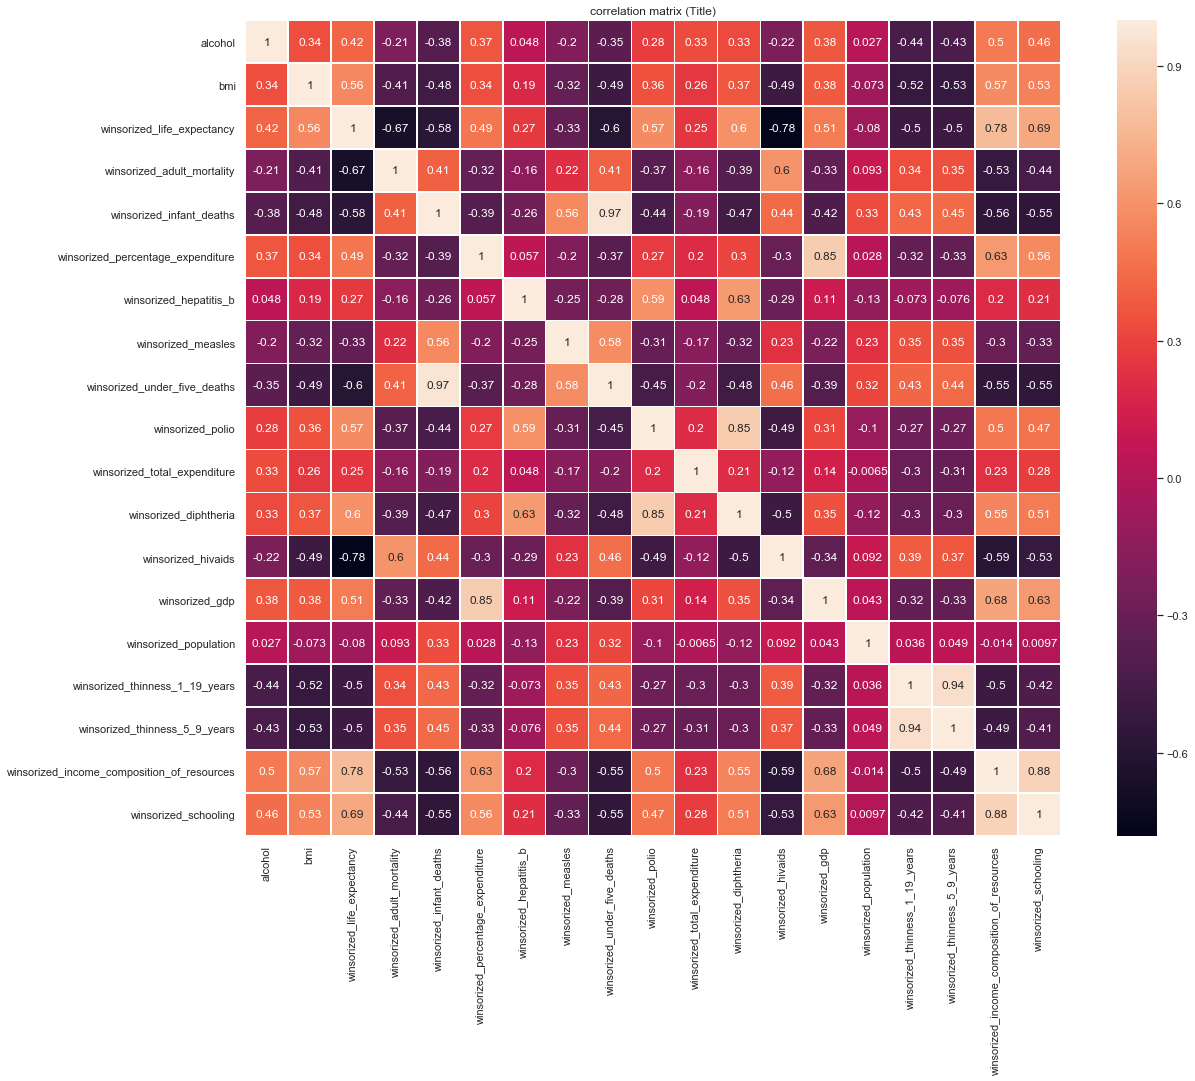

In [369]:
# heatmap

plt.figure(figsize=(20,15))
sns.heatmap(df[features].corr(), square=True, annot=True, linewidths=.5)
plt.title("correlation matrix (Title)")
plt.show()

In [371]:
# correlation

corr=df[features].corr()
corr[corr>0.8]

# 0.812669	winsorized_life_expectancy ; winsorized_income_composition_of_resources
# 0.971722	winsorized_infant_deaths; winsorized_under_five_deaths
# 0.851109	winsorized_polio;  winsorized_diphtheria	
# 0.946349	winsorized_thinness_1_19_years; winsorized_thinness_5_9_years


target=corr.iloc[:, [2]]
target.sort_values(by='winsorized_life_expectancy')


# top 3 from correlation table: 
#winsorized_income_composition_of_resources (+); winsorized_schooling(+); winsorized_hivaids(-)

,winsorized_life_expectancy
winsorized_hivaids,-0.781438
winsorized_adult_mortality,-0.668152
winsorized_under_five_deaths,-0.595706
winsorized_infant_deaths,-0.580872
winsorized_thinness_5_9_years,-0.495562
winsorized_thinness_1_19_years,-0.495283
winsorized_measles,-0.327496
winsorized_population,-0.080265
winsorized_total_expenditure,0.248512
winsorized_hepatitis_b,0.267674


Text(0.5, 1.0, 'HIV/AIDS vs. Life Expectancy')

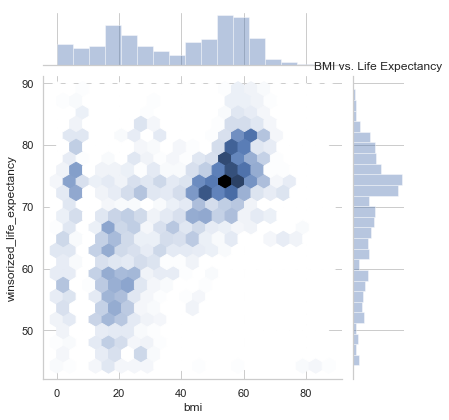

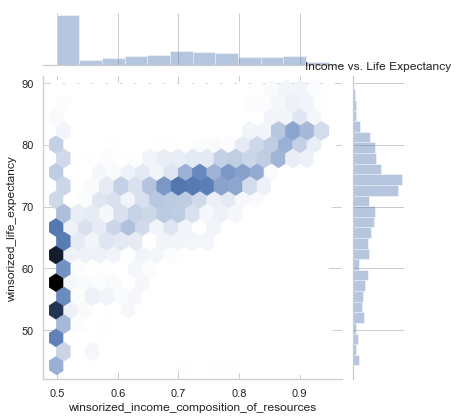

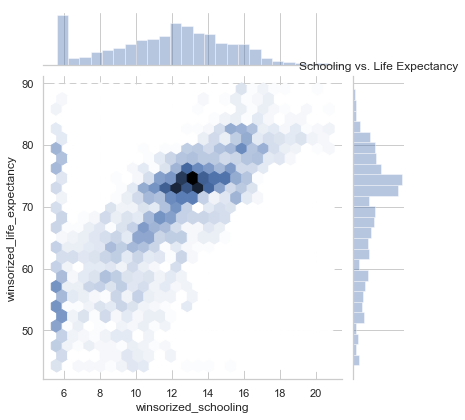

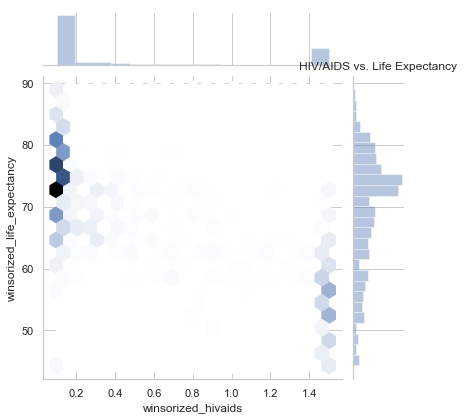

In [372]:
ax = sns.jointplot(x="bmi", y="winsorized_life_expectancy", data=df, kind="hex");
plt.title('BMI vs. Life Expectancy')

ax = sns.jointplot(x="winsorized_income_composition_of_resources", y="winsorized_life_expectancy", data=df, kind="hex");
plt.title('Income vs. Life Expectancy')

ax = sns.jointplot(x="winsorized_schooling", y="winsorized_life_expectancy", data=df, kind="hex");
plt.title('Schooling vs. Life Expectancy')

ax = sns.jointplot(x="winsorized_hivaids", y="winsorized_life_expectancy", data=df, kind="hex");
plt.title('HIV/AIDS vs. Life Expectancy')

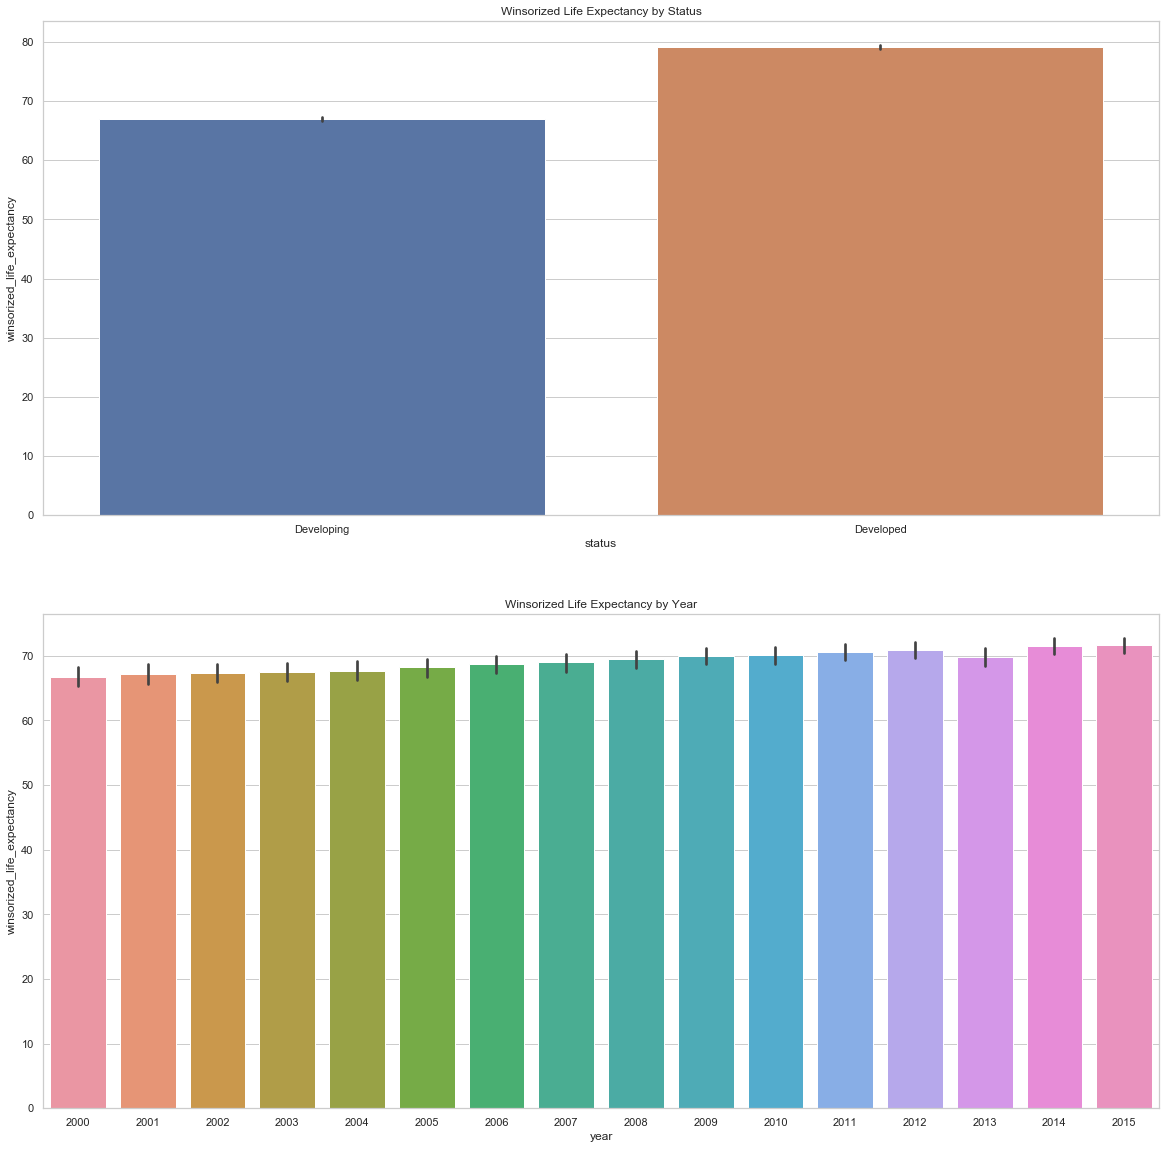

,winsorized_life_expectancy
country,
Afghanistan,58.19375
Albania,75.15625
Algeria,73.61875
Angola,49.01875
Antigua and Barbuda,75.05625
Argentina,75.15625
Armenia,73.40000
Australia,81.81250
Austria,81.48125


In [373]:
# look at the categorical variables: country ; year ; status 

plt.figure(figsize=(20,20))

plt.subplot(2,1,1)
ax = sns.barplot(x="status", y="winsorized_life_expectancy",data=df)
plt.title('Winsorized Life Expectancy by Status')
# developed countries has longer life expectancy

plt.subplot(2,1,2)
ax = sns.barplot(x="year", y="winsorized_life_expectancy",data=df)
plt.title('Winsorized Life Expectancy by Year')
# life expectancy increases with years

plt.show()

df[['country','winsorized_life_expectancy']].groupby(['country']).mean()

# 3. In the feature engineering step, you need to select a suite of variables that you think would be ideal in the modeling phase. More concretely, you may discard some variables that are very correlated with the other ones or the variables that you think irrelevant with the life expectancy.

# Target Variable: 
winsorized_life_expectancy

# top 3 from correlation table: 
winsorized_income_composition_of_resources (+); 
winsorized_schooling(+); 
winsorized_hivaids(-)

# plue one for categorical varaiel 
status 

# below are other highly(>0.8) correlated variables-->can drop one in each group:
 0.971722	winsorized_infant_deaths; winsorized_under_five_deaths
 0.851109	winsorized_polio;  winsorized_diphtheria	
 0.946349	winsorized_thinness_1_19_years; winsorized_thinness_5_9_years


In [377]:
# first -- use jarque_bera and normaltest to check the normality
'''
# Target Variable: 
winsorized_life_expectancy

# top 3 from correlation table: 
winsorized_income_composition_of_resources (+); 
winsorized_schooling(+); 
winsorized_hivaids(-)
'''

from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(df["winsorized_life_expectancy"])
norm_stats = normaltest(np.sqrt(df["winsorized_life_expectancy"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df["winsorized_income_composition_of_resources"])
norm_stats = normaltest(np.sqrt(df["winsorized_income_composition_of_resources"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

jb_stats = jarque_bera(df["winsorized_schooling"])
norm_stats = normaltest(np.sqrt(df["winsorized_schooling"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


jb_stats = jarque_bera(df["winsorized_hivaids"])
norm_stats = normaltest(np.sqrt(df["winsorized_hivaids"]))
print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))


Jarque-Bera test statistics is 207.49432606992812 and p value is 0.0
Normality test statistics is 239.0692168549682 and p value is 1.221178539219939e-52
Jarque-Bera test statistics is 227.85498050885718 and p value is 0.0
Normality test statistics is 9.53085512448236 and p value is 0.008519244956123762
Jarque-Bera test statistics is 60.259320161565014 and p value is 8.215650382226158e-14
Normality test statistics is 161.0886310828582 and p value is 1.047244797816864e-35
Jarque-Bera test statistics is 656.7163941184633 and p value is 0.0
Normality test statistics is 633.6857409897336 and p value is 2.4939613209877266e-138


The p-values are close to 0 which indicates that the distribution of target variables is statistically different from the normal distribution. I will apply the BoxCox this transformation.

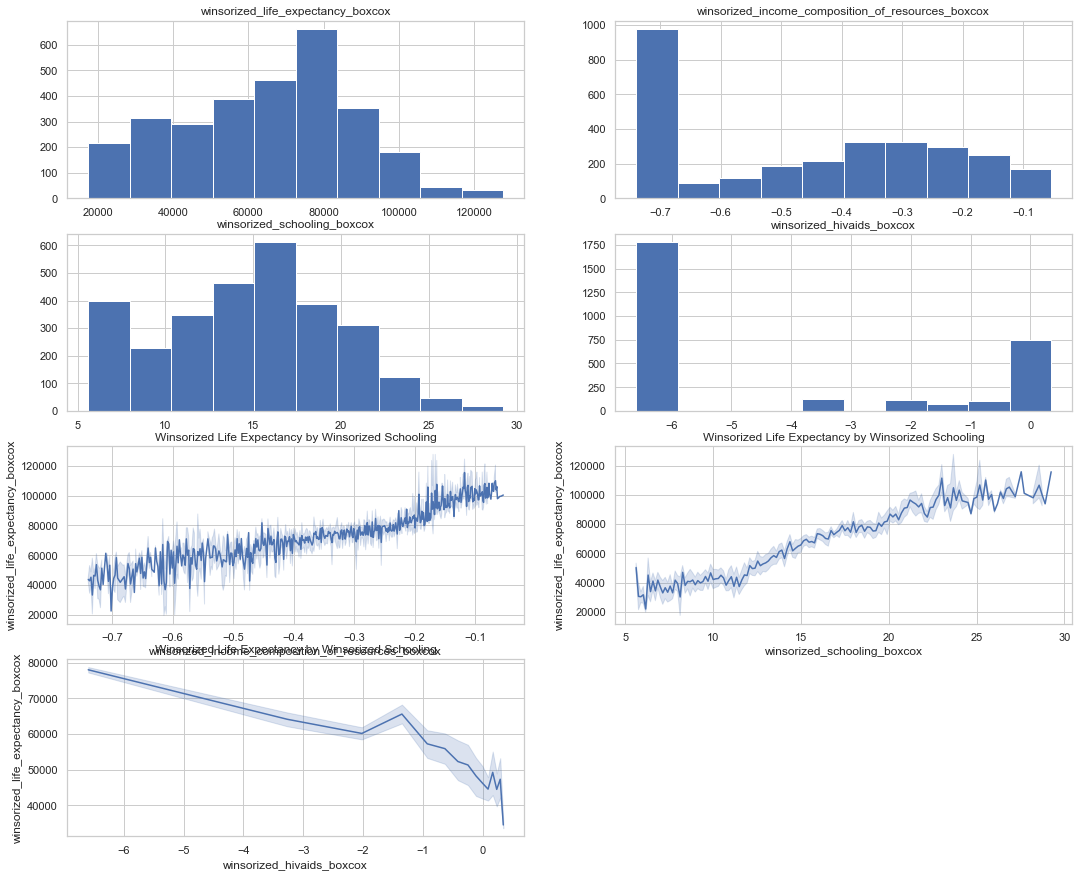

In [383]:
'''
# Target Variable: 
winsorized_life_expectancy

# top 3 from correlation table: 
winsorized_income_composition_of_resources (+); 
winsorized_schooling(+); 
winsorized_hivaids(-)
'''

from scipy.stats import boxcox

winsorized_life_expectancy_boxcox,_ = boxcox(df["winsorized_life_expectancy"])
winsorized_income_composition_of_resources_boxcox,_ = boxcox(df["winsorized_income_composition_of_resources"])
winsorized_schooling_boxcox,_ = boxcox(df["winsorized_schooling"])
winsorized_hivaids_boxcox,_ = boxcox(df["winsorized_hivaids"])


plt.figure(figsize=(18,15))

# histograms of the box-cox transformed data
plt.subplot(4, 2, 1)
plt.hist(winsorized_life_expectancy_boxcox)
plt.title("winsorized_life_expectancy_boxcox")

plt.subplot(4, 2, 2)
plt.hist(winsorized_income_composition_of_resources_boxcox)
plt.title("winsorized_income_composition_of_resources_boxcox")

plt.subplot(4, 2, 3)
plt.hist(winsorized_schooling_boxcox)
plt.title("winsorized_schooling_boxcox")

plt.subplot(4, 2, 4)
plt.hist(winsorized_hivaids_boxcox)
plt.title("winsorized_hivaids_boxcox")



df['winsorized_life_expectancy_boxcox']=winsorized_life_expectancy_boxcox
df['winsorized_income_composition_of_resources_boxcox']=winsorized_income_composition_of_resources_boxcox
df['winsorized_schooling_boxcox']=winsorized_schooling_boxcox
df['winsorized_hivaids_boxcox']=winsorized_hivaids_boxcox

plt.subplot(4, 2, 5)
sns.lineplot(x="winsorized_income_composition_of_resources_boxcox", y="winsorized_life_expectancy_boxcox",data=df)
plt.title('Winsorized Life Expectancy by Winsorized Schooling')

plt.subplot(4, 2, 6)
sns.lineplot(x="winsorized_schooling_boxcox", y="winsorized_life_expectancy_boxcox",data=df)
plt.title('Winsorized Life Expectancy by Winsorized Schooling')

plt.subplot(4, 2, 7)
sns.lineplot(x="winsorized_hivaids_boxcox", y="winsorized_life_expectancy_boxcox",data=df)
plt.title('Winsorized Life Expectancy by Winsorized Schooling')


plt.show()

In [390]:
# plue one for categorical varaiel --- status 

pd.get_dummies(df["status"])

#df = pd.concat([df, pd.get_dummies(df["status"])], axis=1)
#df

,Developed,Developing
0,0,1
1,0,1
2,0,1
3,0,1
4,0,1
5,0,1
6,0,1
7,0,1
8,0,1
9,0,1


In [404]:
# now apple PCA to aboev features

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

final_features=['winsorized_life_expectancy_boxcox','winsorized_income_composition_of_resources_boxcox',
                'winsorized_schooling_boxcox','winsorized_hivaids_boxcox']


X = df[['winsorized_income_composition_of_resources_boxcox','winsorized_schooling_boxcox','winsorized_hivaids_boxcox']]

standardscalar=StandardScaler()
x_scaler=standardscalar.fit_transform(X)

sklearn_pca = PCA(n_components=3)   
df["pca_1"] = sklearn_pca.fit_transform(x_scaler)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

# More than 86% of the total variance is explained by the first two principal components.

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [0.79541924 0.16998178 0.03459898]


In [406]:
df[['winsorized_life_expectancy_boxcox',"pca_1", 'winsorized_income_composition_of_resources_boxcox',
                'winsorized_schooling_boxcox','winsorized_hivaids_boxcox']].corr()

,winsorized_life_expectancy_boxcox,pca_1,winsorized_income_composition_of_resources_boxcox,winsorized_schooling_boxcox,winsorized_hivaids_boxcox
winsorized_life_expectancy_boxcox,1.000000,0.837187,0.799202,0.706703,-0.737529
pca_1,0.837187,1.000000,0.951571,0.922325,-0.793781
winsorized_income_composition_of_resources_boxcox,0.799202,0.951571,1.000000,0.889322,-0.628484
winsorized_schooling_boxcox,0.706703,0.922325,0.889322,1.000000,-0.544642
winsorized_hivaids_boxcox,-0.737529,-0.793781,-0.628484,-0.544642,1.000000


pca_1 is more correlated with winsorized_life_expectancy_boxcox than the the rest. 
Hence using pca_1 makes more sense. 
PCA works best when the correlation between the variables are less than and equal to 0.8. In our case, two out of three are less than 0.8.


separately speaking, the features that are affecting the life expectancy are:
1. income_composition_of_resources (Postive features); 
2. schooling (Postive features); 
3. staus (Postive features);
3. hiv/aids(Nagative features)
